100%|██████████| 10000/10000 [00:11<00:00, 880.28it/s]


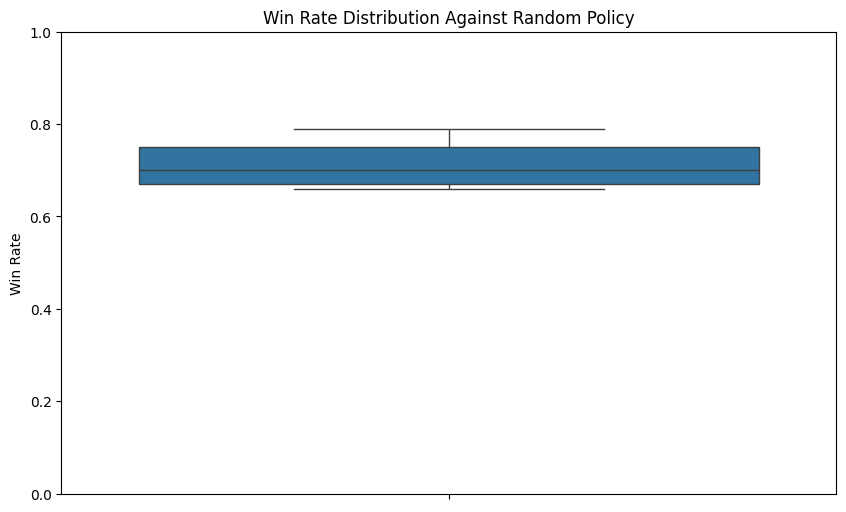

Final average win rate: 0.710
Standard deviation: 0.041


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from collections import defaultdict

class TicTacToe4x4:
    def __init__(self):
        self.board = np.zeros((4, 4))
        self.current_player = 1  # 1 for X, -1 for O

    def reset(self):
        self.board = np.zeros((4, 4))
        self.current_player = 1
        return self.get_state()

    def get_state(self):
        return str(self.board.tolist())

    def get_valid_moves(self):
        return [(i, j) for i in range(4) for j in range(4) if self.board[i][j] == 0]

    def make_move(self, move):
        i, j = move
        if self.board[i][j] != 0:
            return False
        self.board[i][j] = self.current_player
        return True

    def check_winner(self):
        # Check rows, columns and diagonals
        for i in range(4):
            if abs(sum(self.board[i,:])) == 4:
                return self.board[i,0]
            if abs(sum(self.board[:,i])) == 4:
                return self.board[0,i]

        # Diagonals
        if abs(sum(np.diag(self.board))) == 4:
            return self.board[0,0]
        if abs(sum(np.diag(np.fliplr(self.board)))) == 4:
            return self.board[0,3]

        # Check for draw
        if len(self.get_valid_moves()) == 0:
            return 0

        return None

    def step(self, action):
        if not self.make_move(action):
            return self.get_state(), -10, True

        winner = self.check_winner()
        done = winner is not None

        reward = 0
        if done:
            if winner == 1:
                reward = 1
            elif winner == -1:
                reward = -1

        self.current_player *= -1
        return self.get_state(), reward, done

class ValueIteration:
    def __init__(self, gamma=0.9):
        self.values = defaultdict(float)
        self.gamma = gamma

    def get_action(self, state, valid_moves, epsilon=0):
        if random.random() < epsilon:
            return random.choice(valid_moves)

        best_value = float('-inf')
        best_action = None

        for action in valid_moves:
            state_value = self.values[f"{state}_{action}"]
            if state_value > best_value:
                best_value = state_value
                best_action = action

        return best_action or random.choice(valid_moves)

    def update(self, state, action, reward, next_state, done):
        state_action = f"{state}_{action}"
        if done:
            self.values[state_action] = reward
        else:
            self.values[state_action] = reward + self.gamma * max(
                [self.values[f"{next_state}_{a}"] for a in [(i,j) for i in range(4) for j in range(4)]]
                + [0]
            )

def play_game(agent, env, epsilon=0, train=True):
    state = env.reset()
    done = False

    while not done:
        valid_moves = env.get_valid_moves()

        if env.current_player == 1:  # Agent's turn
            action = agent.get_action(state, valid_moves, epsilon)
        else:  # Random opponent
            action = random.choice(valid_moves)

        next_state, reward, done = env.step(action)

        if train and env.current_player == -1:  # Only train on agent's moves
            agent.update(state, action, reward, next_state, done)

        state = next_state

    return reward

# Training
episodes = 10000
evaluation_games = 100
evaluation_intervals = 500
win_rates = []

env = TicTacToe4x4()
agent = ValueIteration()

# Training loop
for episode in tqdm(range(episodes)):
    epsilon = max(0.01, 1.0 - episode/episodes)  # Decay epsilon
    play_game(agent, env, epsilon=epsilon, train=True)

    # Evaluate every evaluation_interval episodes
    if (episode + 1) % evaluation_intervals == 0:
        wins = 0
        for _ in range(evaluation_games):
            reward = play_game(agent, env, epsilon=0, train=False)
            if reward == 1:  # Agent won
                wins += 1
        win_rates.append(wins/evaluation_games)

# Plotting
plt.figure(figsize=(10, 6))
sns.boxplot(data=win_rates)
plt.title('Win Rate Distribution Against Random Policy')
plt.ylabel('Win Rate')
plt.ylim(0, 1)
plt.show()

# Print final statistics
print(f"Final average win rate: {np.mean(win_rates):.3f}")
print(f"Standard deviation: {np.std(win_rates):.3f}")